In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from src.utils import construct_sparse_adj_mat, load_json
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from Bio import Align

In [2]:
filepaths = OmegaConf.load('../configs/filepaths/base.yaml')

In [3]:
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
strategy = 'homology'
metric = 'gsi'


reactions = load_json(Path(filepaths.data) / dataset / (toc + ".json"))
adj, idx_sample, idx_feature = construct_sparse_adj_mat(
        Path(filepaths.data) / 'sprhea' / (toc + ".csv")
    )

reactions = {k: v for k, v in reactions.items() if k in idx_feature.values()}

split_dir = Path(filepaths.scratch) / f"{dataset}_{toc}/{strategy}/3fold"

train_val = []
for i in range(3):
    train_val.append(
        pd.read_parquet(split_dir / f"train_val_{i}.parquet")
    )
test = pd.read_parquet(split_dir / 'test.parquet')

Constructing v3_folded_pt_ns sparse adjacency matrix


In [4]:
S = load_similarity_matrix(
    Path(filepaths.results) / "similarity_matrices", 
    dataset,
    toc,
    metric,
)

S = S.astype(np.float16)

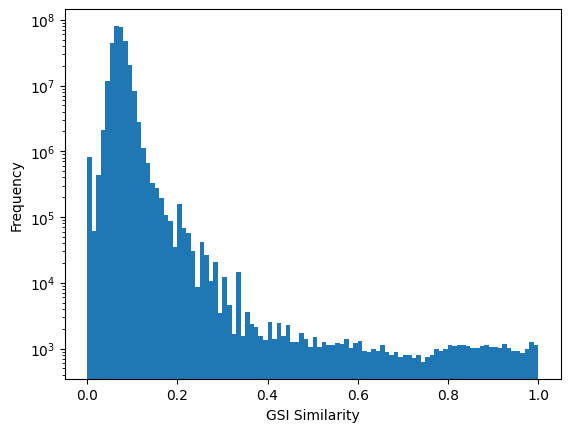

In [5]:
sims = S[np.triu_indices_from(S, k=1)]
plt.hist(sims, bins=100)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel(f"{metric.upper()} Similarity")
plt.show()

In [6]:
train = pd.concat(train_val).reset_index(drop=True)
train_idx = list(set(train['protein_idx']))
test_idx = list(set(test['protein_idx']))
max_sims = S[:, test_idx][train_idx].max(axis=0)

In [7]:
sorted(max_sims, reverse=False)[:20]

[0.08575,
 0.0889,
 0.0892,
 0.0892,
 0.0905,
 0.09174,
 0.09216,
 0.09467,
 0.0949,
 0.0952,
 0.096,
 0.09644,
 0.09766,
 0.09814,
 0.0992,
 0.0992,
 0.1003,
 0.10034,
 0.10046,
 0.1011]

In [8]:
nearest_train_neighbors = S[:, test_idx][train_idx].argmax(axis=0)

In [9]:
len(max_sims[max_sims < 0.25]), len(max_sims)

(1491, 7137)

In [16]:
ub = 0.3
test_idxs = np.nonzero(max_sims < ub)[0]
train_idxs = nearest_train_neighbors[max_sims < ub]
tr_te_pairs = list(zip(train_idx, test_idx))

with open('low_sim_pairs.txt', 'w') as f:
    for pair in tr_te_pairs:
        f.write(f"{pair[0]}\t{pair[1]}\n")

In [ ]:
train.head()

,protein_idx,reaction_idx,pid,rid,protein_embedding,smarts,reaction_center,y
0,14597,4949,Q4AEH5,3465,"[-0.19151253, 0.22544405, 0.006724517, 0.01276...",NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,"[[[9, 10], [0], [0]], [[9], [9], [0, 1]]]",1
1,22499,3152,P19791,446,"[-0.038668983, 0.33085075, -0.18529698, 0.0166...",*OC1C(CO)OC(*)C1O.*C1OC(COP(*)(=O)O)C(OP(=O)(O...,"[[[5], [14, 12]], [[0], [5, 6]]]",1
2,3126,341,Q39086,210,"[-0.057455827, 0.04223725, -0.05662363, 0.0197...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [8, 9]], [[8], [22, 23]]]",1
3,3126,342,Q39086,85,"[-0.057455827, 0.04223725, -0.05662363, 0.0197...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [4, 5]], [[4], [22, 23]]]",1
4,21300,6068,Q5FW37,56,"[0.007033832, 0.16739662, 0.09198507, -0.00344...",CSCCC(=O)C(=O)COP(=O)(O)O.O>>CSCC(O)C(O)C(=O)C...,"[[[3, 4, 5], [0]], [[3, 4, 5, 6]]]",1


In [28]:
df = pd.read_csv(
    Path(filepaths.data) /  dataset / (toc + ".csv"),
    sep='\t'
)
df.head()

,Entry,Label,Sequence
0,P0A6W3,1123,MLVWLAEHLVKYYSGFNVFSYLTFRAIVSLLTALFISLWMGPRMIA...
1,P9WMW7,1123,MRQILIAVAVAVTVSILLTPVLIRLFTKQGFGHQIREDGPPSHHTK...
2,O66465,1123,MLYQLALLLKDYWFAFNVLKYITFRSFTAVLIAFFLTLVLSPSFIN...
3,Q8MJ30,3097;7946,MAAAAAGEARRVLVYGGRGALGSRCVQAFRARNWWVASIDVVENEE...
4,P38489,3097;7946,MDIISVALKRHSTKAFDASKKLTPEQAEQIKTLLQYSPSSTNSQPW...


In [29]:
i = 0

In [69]:
tr_pair, te_pair = tr_te_pairs[i]
tr_upid = train.loc[train['protein_idx'] == tr_pair, 'pid'].values[0]
te_upid = test.loc[test['protein_idx'] == te_pair, 'pid'].values[0]
print(f"Train {tr_upid}")
tr_seq = df.loc[df['Entry'] == tr_upid, 'Sequence'].values[0]
print(tr_seq)
print(f"Test {te_upid}")
te_seq = df.loc[df['Entry'] == te_upid, 'Sequence'].values[0]
print(te_seq)
i += 1

Train Q8MJ30
MAAAAAGEARRVLVYGGRGALGSRCVQAFRARNWWVASIDVVENEEASANVVVKMTDSFTEQADQVTAEVGKLLGTEKVDAILCVAGGWAGGNAKSKSLFKNCDLMWKQSMWTSTISSHLATKHLKEGGLLTLAGAKAALDGTPGMIGYGMAKGAVHQLCQSLAGKDSGMPSGAAAIAVLPVTLDTPLNRKSMPHADFSSWTPLEFLVETFHDWIIEKNRPSSGSLIQVVTTQGKTELTPAYF
Test Q91610
MPAVRIVILAICCGLLLVPVRCCGPGRGPVGRRRYMRKLVPLHYKQFVPNVPEKTLGASGKSEGKIHRGSERFIELVPNYNPDIIFKDEEKTGADRLMTERCKDRVNALAISVMNMWPGVKLRVTEGWDEDGHHAHDSLHYEGRALDITTSDRDRNKYGMLARLAVEAGFDWVYYESKAHIHVSVKADNSLGVRSGGCFPGTAMVMMGTGERKPLSELKIGDTVYTTDETGQLITSVVLLFLHRNPYKTATFVLIEAEGHPSKLLVTPNHLLFIQSSSSAGFLPTFAYRVQIGDLVQIYVNGTQVQSSKVVRVSLEEQTGVYAPMTEHGTLLVDGVLTSCYATVESHTLAHVSLAPLRLFQGIASMLPDLDMSDGVHWYCHILYVLAKYVLWWDMP


In [70]:
aligner = Align.PairwiseAligner(
    mode="global",
    scoring="blastp"
)
aligner.open_gap_score = -1e6
alignment = aligner.align(tr_seq, te_seq)[0]
t_segments, q_segments = alignment.aligned

talign = ''
qalign = ''
for i in range(t_segments.shape[0]):
    talign += alignment.target[t_segments[i, 0] : t_segments[i, 1]]
    qalign += alignment.query[q_segments[i, 0] : q_segments[i, 1]]

ct = 0
for t, q in zip(talign, qalign):
    if t == q:
        ct += 1

print(ct / min(len(alignment.target), len(alignment.query)))
print(alignment)

0.0823045267489712
target            0 MAAAAAGEARRVLVYGGRGALGSRCVQAFRARNWWVASIDVVENEEASANVVVKMTDSFT
                  0 |.|............................|.................||..|......
query             0 MPAVRIVILAICCGLLLVPVRCCGPGRGPVGRRRYMRKLVPLHYKQFVPNVPEKTLGASG

target           60 EQADQVTAEVGKLLGTEKVDAILCVAGGWAGGNAKSKSLFKNCDLMWKQSMWTSTISSHL
                 60 .................................|.........|................
query            60 KSEGKIHRGSERFIELVPNYNPDIIFKDEEKTGADRLMTERCKDRVNALAISVMNMWPGV

target          120 ATK---------------------------------------------------------
                120 ...---------------------------------------------------------
query           120 KLRVTEGWDEDGHHAHDSLHYEGRALDITTSDRDRNKYGMLARLAVEAGFDWVYYESKAH

target          123 ------------------------------------------------------------
                180 ------------------------------------------------------------
query           180 IHVSVKADNSLGVRSGGCFPGTAMVMMGTGERKPLSELKIGDTVYTTDETGQLITSVVLL

targe